In [2]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data269293


In [3]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

dataset  methods


In [4]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
# !mkdir /home/aistudio/external-libraries
!pip install --upgrade pip
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

Looking in indexes: https://mirror.baidu.com/pypi/simple/, https://mirrors.aliyun.com/pypi/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 504.3 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 22.1.2
    Uninstalling pip-22.1.2:
      Successfully uninstalled pip-22.1.2
Looking in indexes: https://mirror.baidu.com/pypi/simple/, https://mirrors.aliyun.com/pypi/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.9/147.9 kB 516.3 kB/s eta 0:00:00a 0:00:01


In [5]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

# 面向隐私保护深度学习的变换数据分类方法

## 1. 数据处理

In [2]:
#数据处理部分之前的代码，加入部分数据处理的库
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F
import os
import gzip
import json
import random
import numpy as np

In [3]:
labels_dict = {
    'DP-Exponent':0,
    'DP-Gaussian':1,
    'DP-Laplace':2,
    'HE-Elgamal':3,
    # 'HE-Paillier':4,
    'K-anonymity':5,
    'Mosaicing':6,
    'PixelPermutation':7,
    'RandomNoise':8,
    'XOR':9,
    'BlockPerturb':10
}

new_labels_dict = {v : k for k, v in labels_dict.items()}

In [4]:
import matplotlib.pyplot as plt
from paddle.io import Dataset
from paddle.vision.transforms import Compose, Normalize


class MyDataset(Dataset):
    """
    步骤一：继承 paddle.io.Dataset 类
    """

    def __init__(self, data_dir, transform=None):
        """
        步骤二：实现 __init__ 函数，初始化数据集，将样本和标签映射到列表中
        """
        super().__init__()
        # 传入定义好的数据处理方法，作为自定义数据集类的一个属性
        self.transform = transform
        self.data = []

        f = os.listdir(data_dir)

        temp = {'DP-Exponent':0,
    'DP-Gaussian':0,
    'DP-Laplace':0,
    'HE-Elgamal':0,
    # 'HE-Paillier':0,
    'K-anonymity':0,
    'Mosaicing':0,
    'PixelPermutation':0,
    'RandomNoise':0,
    'XOR':0,
    'BlockPerturb':0
    }

        for line in f:
            if line[-3:] != 'npy' or line.split('_')[2][:-4] == 'HE-Paillier':
                continue
            image_path = data_dir + '/' + line
            
            label = line.split('_')[2][:-4]
            temp[label] = temp.get(label) + 1
            # 读取灰度图
            image = np.load(image_path, allow_pickle=True)
            image = self.transform(image)
            self.data.append([image, np.array(labels_dict[label])])
        
        print(temp,len(temp))

        

    def __getitem__(self, index):
        """
        步骤三：实现 __getitem__ 函数，定义指定 index 时如何获取数据，并返回单条数据（样本数据、对应的标签）
        """
        # 根据索引，从列表中取出一个图像
        image, label = self.data[index]
  

        # 飞桨训练时内部数据格式默认为float32，将图像数据格式转换为 float32
        image = image.astype('float32')
        # 应用数据处理方法到图像上
        if self.transform is not None:
            image = self.transform(image)
        # 返回图像和对应标签
        return image, label

    def __len__(self):
        """
        步骤四：实现 __len__ 函数，返回数据集的样本总数
        """
        return len(self.data)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


In [5]:
dataset = MyDataset(data_dir = 'work/dataset',transform = Compose([Normalize(mean=[127.5],std=[127.5],data_format='CHW')]))
image,label = dataset.__getitem__(0)
print(image[0].shape)

{'DP-Exponent': 1000, 'DP-Gaussian': 1000, 'DP-Laplace': 1000, 'HE-Elgamal': 1000, 'K-anonymity': 1000, 'Mosaicing': 1000, 'PixelPermutation': 1000, 'RandomNoise': 1001, 'XOR': 1000, 'BlockPerturb': 1000} 10
(28, 28)


数据集总长度为： 10001
训练集长度为： 7000
测试集长度为： 3001
图像和标签数据类型为 <class 'numpy.ndarray'> <class 'numpy.ndarray'>
图像和标签维度为 (1, 28, 28) ()
第一条数据的标签为: 0   DP-Exponent
[[[-1.         -1.          0.827451    0.9529412  -1.
   -1.         -1.         -1.         -0.3254902  -1.
   -1.          0.99215686 -1.         -1.         -1.
   -1.         -1.         -1.         -1.          0.4745098
   -1.         -1.         -1.         -0.3647059  -1.
   -1.         -0.31764707 -1.        ]
  [-1.         -1.          0.11372549 -1.         -1.
   -1.         -0.8039216  -1.         -1.         -1.
   -1.         -1.         -1.         -1.         -1.
   -1.         -1.         -1.         -1.         -1.
   -1.         -1.          0.9843137  -1.         -1.
   -1.         -1.         -1.        ]
  [ 0.05098039 -1.         -1.         -1.          0.9843137
   -1.         -1.         -1.         -1.          0.9843137
    0.9607843   0.827451   -1.         -1.         -1.
   -1.         -1.         -1.   

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_max = np.asscalar(a_max.astype(scaled_dtype))


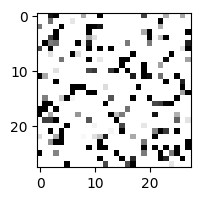

In [6]:
# 测试定义的数据集
random.shuffle(dataset.data)

train_set,test_set = dataset.data[:7000],dataset.data[7000:]
print('数据集总长度为：',dataset.__len__())
print('训练集长度为：',len(train_set))
print('测试集长度为：',len(test_set))

img0,label0 = train_set[0]
print('图像和标签数据类型为',type(img0),type(label0))
print('图像和标签维度为',img0.shape,label0.shape)

print('第一条数据的标签为: ' + str(label0) +"   "+ new_labels_dict[int(label0)])
print(img0,label0)

img0 = img0.reshape([28,28])
plt.figure(figsize=(2,2))
plt.imshow(img0, cmap=plt.cm.binary)


In [7]:
for i in range(len(train_set)):
        img,label = train_set[i]
        # 将数据处理成希望的类型
        print(img.shape)
        break
        # img = img.reshape(1,784)

(1, 28, 28)


In [8]:
# 读入数据时用到的批次大小
BATCHSIZE = 100

# 随机打乱训练数据的索引序号
random.shuffle(train_set)

# 定义数据生成器，返回批次数据
def data_generator():
    imgs_list = []
    labels_list = []
    for i in range(len(train_set)):
        img,label = train_set[i]
        # 将数据处理成希望的类型
        img = img.reshape(784,)
        img = img.astype('float32')
        label = label.astype('float32')

        imgs_list.append(img) 
        labels_list.append(label)
        if len(imgs_list) == BATCHSIZE:
            # 获得一个batchsize的数据，并返回
            yield np.array(imgs_list), np.array(labels_list)
            # 清空数据读取列表
            imgs_list = []
            labels_list = []

    # 如果剩余数据的数目小于BATCHSIZE，
    # 则剩余数据一起构成一个大小为len(imgs_list)的mini-batch
    if len(imgs_list) > 0:
        yield np.array(imgs_list), np.array(labels_list)
    return data_generator

In [9]:
# 声明数据读取函数，从训练集中读取数据
train_loader = data_generator
# 以迭代的形式读取数据
for batch_id, data in enumerate(train_loader()):
    image_data, label_data = data
    if batch_id == 0:
        # 打印数据shape和类型
        print("打印第一个batch数据的维度,以及数据的类型:")
        print("图像维度: {}, 标签维度: {}, 图像数据类型: {}, 标签数据类型: {}".format(image_data.shape, label_data.shape, type(image_data), type(label_data)))
    break

打印第一个batch数据的维度,以及数据的类型:
图像维度: (100, 784), 标签维度: (100,), 图像数据类型: <class 'numpy.ndarray'>, 标签数据类型: <class 'numpy.ndarray'>


In [10]:
# 封装数据读取与处理函数
def load_data(mode = 'train'):

    # 随机打乱训练数据的索引序号
    random.shuffle(train_set)
    # 读入数据时用到的批次大小
    BATCHSIZE = 100

    # 数据集相关参数，图片高度IMG_ROWS, 图片宽度IMG_COLS
    IMG_ROWS = 28
    IMG_COLS = 28

    # 定义数据生成器，返回批次数据
    def data_generator():
        imgs_list = []
        labels_list = []
        if mode == 'eval':
            data_set = test_set
        else:
            data_set = train_set
        for i in range(len(data_set)):
            img,label = train_set[i]
            # 将数据处理成希望的类型
            img = img.reshape(784,)
            # 将数据处理成希望的类型
            # img = img.astype('float32')
            # label = label.astype('float32')

            # 在使用卷积神经网络结构时，uncomment 下面两行代码
            # img = np.reshape(img, [1, IMG_ROWS, IMG_COLS]).astype('float32')
            # label = np.reshape(label, [1]).astype('float32')

            img = np.reshape(img, [1, IMG_ROWS, IMG_COLS]).astype('float32')
            label = np.reshape(label, [1]).astype('int64')

            imgs_list.append(img) 
            labels_list.append(label)
            if len(imgs_list) == BATCHSIZE:
                # 获得一个batchsize的数据，并返回
                yield np.array(imgs_list), np.array(labels_list)
                # 清空数据读取列表
                imgs_list = []
                labels_list = []

        # 如果剩余数据的数目小于BATCHSIZE，
        # 则剩余数据一起构成一个大小为len(imgs_list)的mini-batch
        if len(imgs_list) > 0:
            yield np.array(imgs_list), np.array(labels_list)
    return data_generator

In [11]:
# 测试load_data
train_loader = load_data('train')
for batch_id, data in enumerate(train_loader()):
    print(batch_id,end='\t')

0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	

## 2. 网络结构

In [12]:
import paddle
from paddle.nn import Conv2D, MaxPool2D, Linear
import paddle.nn.functional as F
# 多层卷积神经网络实现
class MNIST(paddle.nn.Layer):
     def __init__(self):
         super(MNIST, self).__init__()
         
         # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
         self.conv1 = Conv2D(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=2)
         # 定义池化层，池化核的大小kernel_size为2，池化步长为2
         self.max_pool1 = MaxPool2D(kernel_size=2, stride=2)
         # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
         self.conv2 = Conv2D(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=2)
         # 定义池化层，池化核的大小kernel_size为2，池化步长为2
         self.max_pool2 = MaxPool2D(kernel_size=2, stride=2)
         # 定义一层全连接层，输出维度是10
         self.fc = Linear(in_features=980, out_features=11)

    # 定义网络前向计算过程，卷积后紧接着使用池化层，最后使用全连接层计算最终输出
    # 卷积层激活函数使用Relu，全连接层激活函数使用softmax
     def forward(self, inputs, label):
         x = self.conv1(inputs)
         x = F.relu(x)
         x = self.max_pool1(x)
         x = self.conv2(x)
         x = F.relu(x)
         x = self.max_pool2(x)
         x = paddle.reshape(x, [x.shape[0], 980])
         x = self.fc(x)
         if label is not None:
             acc = paddle.metric.accuracy(input=x, label=label)
             return x, acc
         else:
             return x


## 3. 模型训练

In [13]:
from visualdl import LogWriter
log_writer = LogWriter("./log")

In [14]:
#网络结构部分之后的代码，保持不变
def train(model):
    model.train()
    #调用加载数据的函数，获得MNIST训练数据集
    train_loader = load_data('train')
    # 使用SGD优化器，learning_rate设置
    # opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())
    #四种优化算法的设置方案，可以逐一尝试效果
    # opt = paddle.optimizer.Momentum(learning_rate=0.001, momentum=0.9, parameters=model.parameters())
    # opt = paddle.optimizer.Adagrad(learning_rate=0.01, parameters=model.parameters())
    opt = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())


    # 训练10轮
    EPOCH_NUM = 10
    iter = 0
    # MNIST图像高和宽
    IMG_ROWS, IMG_COLS = 28, 28
    loss_list = []
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            
            #前向计算的过程
            predicts, acc = model(images, labels)
            
            #计算损失，取一个批次样本损失的平均值
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)

            #每训练10批次的数据，打印下当前Loss的情况
            if batch_id % 10 == 0:
                loss = avg_loss.numpy()[0]
                loss_list.append(loss)
                print("epoch: {}, batch: {}, loss is: {}, acc is {}".format(epoch_id, batch_id, avg_loss.numpy(), acc.numpy()))
                log_writer.add_scalar(tag = 'acc', step = iter, value = acc.numpy())
                log_writer.add_scalar(tag = 'loss', step = iter, value = avg_loss.numpy())
                iter = iter + 100
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.step()
            # 清除梯度
            opt.clear_grad()

    #保存模型参数
    paddle.save(model.state_dict(), 'mnist.pdparams')
    return loss_list

model = MNIST()
loss_list = train(model)

epoch: 0, batch: 0, loss is: [3.358166], acc is [0.09]
epoch: 0, batch: 10, loss is: [1.388452], acc is [0.48]
epoch: 0, batch: 20, loss is: [0.96732324], acc is [0.62]
epoch: 0, batch: 30, loss is: [0.8024245], acc is [0.66]
epoch: 0, batch: 40, loss is: [0.64176667], acc is [0.69]
epoch: 0, batch: 50, loss is: [0.5682642], acc is [0.72]
epoch: 0, batch: 60, loss is: [0.47960934], acc is [0.77]
epoch: 1, batch: 0, loss is: [0.44080174], acc is [0.84]
epoch: 1, batch: 10, loss is: [0.49561524], acc is [0.67]
epoch: 1, batch: 20, loss is: [0.43548274], acc is [0.83]
epoch: 1, batch: 30, loss is: [0.42493802], acc is [0.82]
epoch: 1, batch: 40, loss is: [0.50480485], acc is [0.83]
epoch: 1, batch: 50, loss is: [0.39537528], acc is [0.84]
epoch: 1, batch: 60, loss is: [0.30289578], acc is [0.89]
epoch: 2, batch: 0, loss is: [0.3103153], acc is [0.87]
epoch: 2, batch: 10, loss is: [0.28968155], acc is [0.88]
epoch: 2, batch: 20, loss is: [0.29687235], acc is [0.87]
epoch: 2, batch: 30, los

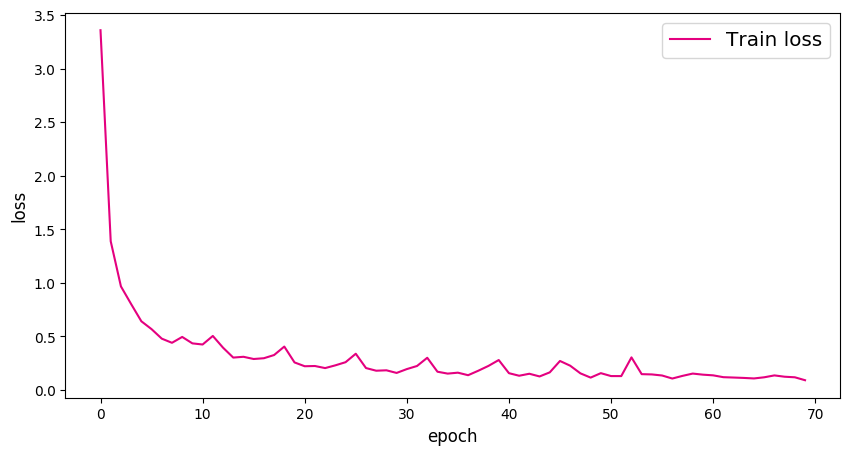

In [15]:
EPOCH_NUM = 10
def plot(loss_list):
    plt.figure(figsize=(10,5))
    
    epoch = [i for i in range(70)]
    # 绘制训练损失变化曲线
    plt.plot(epoch, loss_list, color='#e4007f', label="Train loss")
    
    # 绘制坐标轴和图例
    plt.ylabel("loss", fontsize='large')
    plt.xlabel("epoch", fontsize='large')
    plt.legend(loc='upper right', fontsize='x-large')
    
    plt.show()

plot(loss_list)

## 4. 模型预测

In [16]:
def evaluation(model):
    print('start evaluation .......')
    # 定义预测过程
    params_file_path = 'mnist.pdparams'
    # 加载模型参数
    param_dict = paddle.load(params_file_path)
    model.load_dict(param_dict)

    model.eval()
    eval_loader = load_data('eval')

    acc_set = []
    avg_loss_set = []
    for batch_id, data in enumerate(eval_loader()):
        images, labels = data
        images = paddle.to_tensor(images)
        labels = paddle.to_tensor(labels)
        predicts, acc = model(images, labels)
        loss = F.cross_entropy(input=predicts, label=labels)
        avg_loss = paddle.mean(loss)
        acc_set.append(float(acc.numpy()))
        avg_loss_set.append(float(avg_loss.numpy()))
    
    #计算多个batch的平均损失和准确率
    acc_val_mean = np.array(acc_set).mean()
    avg_loss_val_mean = np.array(avg_loss_set).mean()

    print('loss={}, acc={}'.format(avg_loss_val_mean, acc_val_mean))

model = MNIST()
evaluation(model)

start evaluation .......
loss=0.17921963413720088, acc=0.9048387100619655


## 5. 可视化分析

In [33]:
# 安装VisualDL
!pip install --upgrade pip
!pip install --upgrade --pre visualdl

Looking in indexes: https://mirror.baidu.com/pypi/simple/, https://mirrors.aliyun.com/pypi/simple/
Looking in indexes: https://mirror.baidu.com/pypi/simple/, https://mirrors.aliyun.com/pypi/simple/


In [ ]:
!visualdl --logdir ./log --port 8080

VisualDL 2.5.3
Running VisualDL at http://localhost:8080/ (Press CTRL+C to quit)
Serving VisualDL on localhost; to expose to the network, use a proxy or pass --host 0.0.0.0
